In [1]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set(style="darkgrid", palette="muted", font="serif")
plt.rcParams.update(plt.rcParamsDefault)
import pickle
import pandas as pd

from abc import ABC, abstractmethod
import time, random, itertools
from typing import Callable, Tuple, List, Optional
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
import tqdm

from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *
from scripts.ra import *
plt.rcParams['xtick.labelsize'], plt.rcParams['ytick.labelsize'] = 14,14  
plt.rcParams["font.family"] = "serif"
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts (editable in Illustrator)
mpl.rcParams['ps.fonttype'] = 42   # Same for EPS
mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG
set_seed(313)

In [2]:
#centering and scaling
def normalize_scale_pair(trajectories_target_full, training_pairs=False):
    # Compute mean and std for normalization
    mean = trajectories_target_full.mean(dim=(0, 1), keepdim=True)
    std = trajectories_target_full.std(dim=(0, 1), keepdim=True)

    # Apply normalization
    trajectories_target_full = (trajectories_target_full - mean) / std

    if training_pairs:
        # Generate training pairs
        trajectories_target = make_transition_pairs(trajectories_target_full)
    else:
        # Use full trajectories
        trajectories_target = trajectories_target_full.clone()
    
    return trajectories_target_full, trajectories_target, mean, std

In [3]:
set_seed(313)
dim = 2
homeo_type = 'node'
layer_sizes = 1*[128]
homeo_mean = 0.02  #0.02
homeo_std = 0.5 #0.25
target_homeo_params = {'homeo_type': homeo_type, 'dim': 2, 'layer_sizes': layer_sizes, 'init_type': 'small', 'activation': nn.ReLU, 'init_mean': homeo_mean, 'init_std': homeo_std}
#target_homeo_params = {'homeo_type': homeo_type, 'dim': 2, 'layer_sizes': layer_sizes, 'init_type': 'scaled', 'activation': nn.ReLU, 'init_mean': homeo_mean, 'init_std': homeo_std}
target_homeo = build_homeomorphism(target_homeo_params)

id_homeo_params = {'homeo_type': homeo_type, 'dim': 2, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': 'identity'}
id_homeo = build_homeomorphism(id_homeo_params)

dt=.2
time_span = torch.tensor([0.0, 2.]) 
train_ratio = 0.8
simulation_params = {'initial_conditions_mode': 'random', 'number_of_target_trajectories': 50, 'time_span': time_span, 'dt': dt, 'noise_std': .0,
                     'training_pairs': False, 'margin': 0.5, 'seed': 42, 'train_ratio': train_ratio}
generator_ra = AnalyticalRingAttractor(dim=dim, dt=dt, time_span=time_span) 
# generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=simulation_params['noise_std'])
init_conds = prepare_initial_conditions(mode=simulation_params['initial_conditions_mode'], num_points=simulation_params['number_of_target_trajectories'], margin=simulation_params['margin'], seed=simulation_params['seed'])
ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))
trajectories_target_full = target_homeo(ra_trajs)
trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target_full, simulation_params['training_pairs'])

N = trajectories_target_full.shape[0]
n_train = int(train_ratio * N)
n_test = N - n_train
train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
trajectories_target_train = trajectories_target[train_set.indices]
trajectories_target_test = trajectories_target[test_set.indices]
trajectories_target_train.shape

torch.Size([40, 10, 2])

In [5]:
# fig, ax = plt.subplots(figsize=(5, 5))

# for alpha in np.linspace(0, .99, 2):
#     interpolated_homeo = rescale_node_vf(target_homeo, alpha)
#     trajectories_target_full = interpolated_homeo(ra_trajs)
#     trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target_full, simulation_params['training_pairs'])
#     train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
#     trajectories_target_train = trajectories_target[train_set.indices]
#     trajectories_target_test = trajectories_target[test_set.indices]
#     for i in range(trajectories_target.shape[0]):
#         ax.plot(trajectories_target[i, :, 0].detach().numpy(), trajectories_target[i, :, 1].detach().numpy(), 'k-+', lw=2, alpha=0.5)
# plt.show()

In [63]:
homeo_type = 'node'
layer_sizes = 1*[64]
init_type = 'small'
homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU} #, 'init_type': init_type}
homeo_lc = build_homeomorphism(homeo_params)

ds_motif = 'ring' #'lc', 'bla', 'stable', 'square',  
analytic = True
vf_on_ring_enabled = False #if analytic then not used
alpha_init = None
if simulation_params['training_pairs']:
    time_span = torch.tensor([0.0, dt])
ds_params = {'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span, 'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled, 'alpha_init': alpha_init}
source_system_ra = build_ds_motif(**ds_params)
homeo_ds_net = Homeo_DS_Net(homeo_lc, source_system_ra)

lr = 0.01
num_epochs = 500
annealing_params = {'dynamic': False, 'initial_std': .0, 'final_std': 0.}
training_params = {'lr': lr, 'num_epochs': num_epochs, 'annealing_params': annealing_params, 'early_stopping_patience': 1000, "batch_size": 32,
                   'use_inverse_formulation': True}

homeo_ds_net = train_homeo_ds_net_batched(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train, **training_params)
homeo_ds_net.training_params = training_params
homeo_ds_net.ds_params = ds_params
homeo_ds_net.homeo_params = homeo_params
homeo_ds_net.eval();
#save_homeo_ds_net(homeo_ds_networks[0], f"model_pnorm{norm}_irn_.pth")

Epoch 0, log(Loss)= -1.0341
Epoch 10, log(Loss)= -1.3924
Epoch 20, log(Loss)= -1.6418
Epoch 30, log(Loss)= -1.6452
Epoch 40, log(Loss)= -1.4630
Epoch 50, log(Loss)= -1.7133


KeyboardInterrupt: 

Train loss: -2.0530071512891497 Test loss: -1.6937151295513455 Jacobian norm: 0.6803928017616272


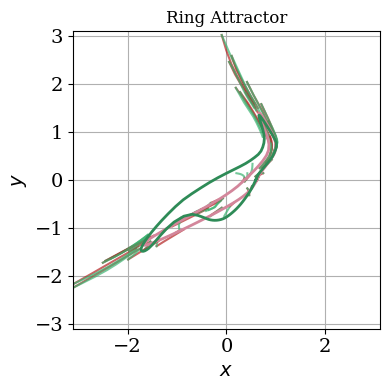

In [ ]:
plot_first_n = simulation_params['number_of_target_trajectories']
jac_norm = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1,dim))
homeo_ds_net.jac_norm = jac_norm
trajectories_source, transformed_trajectories, test_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_test)
trajectories_source, transformed_trajectories, train_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target)
fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network)
target_ra_points = get_homeo_invman(interpolated_homeo)
target_ra_points = (target_ra_points - mean.detach().numpy()) / std.detach().numpy() 
print(f"Train loss: {np.log10(train_loss)}", f"Test loss: {np.log10(test_loss)}", f"Jacobian norm: {jac_norm}")
plot_single_motif_trajectories(trajectories_source=trajectories_source, transformed_trajectories=transformed_trajectories, trajectories_target=trajectories_target_full.detach().numpy(), num_points=plot_first_n, which_axis='second', 
                            asymptotic_source_transformed=fit_ra_points, asymptotic_target=target_ra_points[0], bounds='from_targ_traj', 
                            source_name='Ring Attractor', show_fig=True,save_name=f"figures/ring_perthom.pdf")

In [101]:

def perthomeo_exp(random_seed=313):
    save_dir = "experiments/homeopert_ring"
    set_seed(random_seed)
    homeo_type = 'node'
    layer_sizes = 1*[128]
    homeo_mean = 0.02  #0.02
    homeo_std = 0.5 #0.25
    dim=2
    target_homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'init_type': 'small', 'activation': nn.ReLU, 'init_mean': homeo_mean, 'init_std': homeo_std}
    target_homeo = build_homeomorphism(target_homeo_params)
    save_homeo_ds_net(target_homeo, f"{save_dir}/target_homeo.pth")

    dt=.2
    time_span = torch.tensor([0.0, 2.]) 
    train_ratio = 0.8
    ds_motif = 'ring' 
    analytic = True
    vf_on_ring_enabled = True #if analytic then not used
    training_pairs = False
    alpha_init = None
    if training_pairs:
        time_span = torch.tensor([0.0, dt])
    ds_params = {'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span, 'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled, 'alpha_init': alpha_init}
    simulation_params = {'initial_conditions_mode': 'random', 'number_of_target_trajectories': 50, 'time_span': time_span, 'dt': dt, 'noise_std': .0,
                        'training_pairs': training_pairs, 'margin': 0.5, 'seed': 42, 'train_ratio': train_ratio, 'ds_params': ds_params}
    
    homeo_type = 'node'
    layer_sizes = 1*[128]
    init_type = None
    homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': init_type}

    lr = 0.01
    num_epochs = 1000
    annealing_params = {'dynamic': False, 'initial_std': .0, 'final_std': 0.}
    training_params = {'lr': lr, 'num_epochs': num_epochs, 'annealing_params': annealing_params, 'early_stopping_patience': 1000, "batch_size": 32,
                    'use_inverse_formulation': True}
    
    all_parameters = {'target_homeo_params': target_homeo_params, 'homeo_params': homeo_params, 'training_params': training_params, 'simulation_params': simulation_params}
    with open("parameters.pkl", "wb") as f:
        pickle.dump(all_parameters, f)
    
    # generate ring attractor trajectories
    generator_ra = AnalyticalRingAttractor(dim=dim, dt=dt, time_span=time_span) 
    # generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=simulation_params['noise_std'])
    init_conds = prepare_initial_conditions(mode=simulation_params['initial_conditions_mode'], num_points=simulation_params['number_of_target_trajectories'], margin=simulation_params['margin'], seed=simulation_params['seed'])
    ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))

    B = ra_trajs.shape[0]
    n_train = int(train_ratio * B)
    n_test = B - n_train

    results = []
    for interpol_value_i, interpol_value in enumerate(np.linspace(0, 1, 11)):
        interpol_value = round(interpol_value, 2)
        print(f"Interpol value: {interpol_value}")

        interpolated_homeo = rescale_node_vf(target_homeo, interpol_value)
        trajectories_target_full = interpolated_homeo(ra_trajs)
        trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target_full, simulation_params['training_pairs'])
        np.save(f"trajectories_target_full_{interpol_value}.npy", trajectories_target_full.detach().numpy())

        train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
        trajectories_target_train = trajectories_target[train_set.indices]
        trajectories_target_test = trajectories_target[test_set.indices]

        target_ra_points = get_homeo_invman(interpolated_homeo) 
        target_ra_points = (target_ra_points - mean.detach().numpy()) / std.detach().numpy() 

        homeo = build_homeomorphism(homeo_params)
        source_system_ra = build_ds_motif(**ds_params)
        homeo_ds_net = Homeo_DS_Net(homeo, source_system_ra)
        homeo_ds_net, losses, grad_norms = train_homeo_ds_net_batched(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train, **training_params)
        homeo_ds_net.eval()
        
        _, _, training_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train)
        _, _, test_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_test)
        fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network)
        jac_norm = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1,dim))

        results.append({
            "interpol_value": interpol_value,
            "train_loss": training_loss,
            "test_loss": test_loss,
            "jacobian_norm": jac_norm,
            "losses": losses,
            "grad_norms": grad_norms,
            "fit_ra_points": fit_ra_points,
            "target_ra_points": target_ra_points[0],
        })

        save_homeo_ds_net(homeo_ds_net, f"{save_dir}/homeo_{interpol_value}.pth")
        np.save(f"{save_dir}/trajectories_target_{interpol_value}.npy", trajectories_target.detach().numpy())

    df = pd.DataFrame(results)
    df.to_pickle(f"{save_dir}/summary_df.pkl")

In [102]:
#perthomeo_exp() #run time: 1h 28m

In [34]:
all_parameters = pickle.load(open("experiments/homeopert_ring/parameters.pkl", "rb"))
layer_sizes = all_parameters['homeo_params']['layer_sizes']
alpha_init = all_parameters['simulation_params']['ds_params']['alpha_init']
homeo = NODEHomeomorphism(dim=2, layer_sizes=[128])        
dynsys = AnalyticalRingAttractor(dim=2, alpha_init=None)
model = load_homeo_ds_net("experiments/homeopert_ring/homeo_0.6.pth", homeo, dynsys)

Model loaded from experiments/homeopert_ring/homeo_0.6.pth


In [35]:
df = pd.read_pickle("experiments/homeopert_ring/summary_df.pkl")
df

,interpol_value,train_loss,test_loss,jacobian_norm,losses,grad_norms,fit_ra_points,target_ra_points
0,0.0,4.167698e-07,0.000033,tensor(0.2572),"[0.08426676969975233, 0.018001744523644447, 0....","[1.0843791961669922, 0.3158297538757324, 0.295...","[[1.3702333, -0.0979955], [1.3650597, -0.01109...","[[1.3755721, -0.1713312], [1.3727925, -0.08392..."
1,0.1,9.517663e-07,0.000020,tensor(0.3100),"[0.03632454061880708, 0.007417040644213557, 0....","[0.5564582943916321, 0.2267495095729828, 0.154...","[[1.4085637, -0.10318779], [1.395621, -0.02447...","[[1.4162394, -0.19446178], [1.410891, -0.10993..."
2,0.2,3.216456e-06,0.000029,tensor(0.3986),"[0.018071756698191166, 0.015753840561956167, 0...","[0.41418156027793884, 0.07858196645975113, 0.1...","[[1.4225112, -0.30197978], [1.4250791, -0.2232...","[[1.4175823, -0.20083626], [1.4108193, -0.1229..."
3,0.3,8.009809e-06,0.000161,tensor(0.4895),"[0.020566410617902875, 0.012458989396691322, 0...","[0.3711717426776886, 0.07748962193727493, 0.24...","[[1.3864299, -0.30467734], [1.3828254, -0.2188...","[[1.3754812, -0.178245], [1.3586907, -0.102039..."
4,0.4,1.173710e-05,0.000159,tensor(0.7517),"[0.025138624478131533, 0.01865975046530366, 0....","[0.2911936938762665, 0.12526053190231323, 0.24...","[[1.2568318, -0.5383555], [1.2939436, -0.44827...","[[1.3292286, -0.14022405], [1.3189871, -0.0712..."
5,0.5,2.817563e-05,0.000342,tensor(0.8195),"[0.06466112285852432, 0.037002354860305786, 0....","[0.6398155093193054, 0.5167621374130249, 0.448...","[[1.1632416, 0.042382967], [1.1316162, 0.15468...","[[1.2305058, -0.10253197], [1.2264494, -0.0435..."
6,0.6,4.035592e-05,0.000778,tensor(0.8446),"[0.0773789994418621, 0.04935021698474884, 0.03...","[0.6504247784614563, 0.6517007350921631, 0.220...","[[1.0560645, -0.06962439], [1.0496292, 0.03441...","[[1.0857137, -0.06692765], [1.0873526, -0.0159..."
7,0.7,6.396729e-05,0.001448,tensor(1.0013),"[0.08036632463335991, 0.07910997048020363, 0.0...","[0.5911769270896912, 0.590526282787323, 0.3734...","[[0.93128824, 0.07291443], [0.94203913, 0.1521...","[[0.93382674, -0.041582674], [0.9405319, 0.003..."
8,0.8,1.506243e-04,0.001129,tensor(0.9618),"[0.07898695394396782, 0.0519599262624979, 0.04...","[0.6214560270309448, 0.29894980788230896, 0.22...","[[0.8360611, 0.13646698], [0.87291324, 0.23124...","[[0.79993194, -0.024171602], [0.8101882, 0.015..."
9,0.9,2.997859e-03,0.042312,tensor(0.8843),"[0.11016901955008507, 0.03503792965784669, 0.0...","[0.6046119928359985, 0.40687984228134155, 0.10...","[[0.74399877, 0.11219486], [0.7809094, 0.18793...","[[0.6927973, -0.011019763], [0.7065756, 0.0261..."


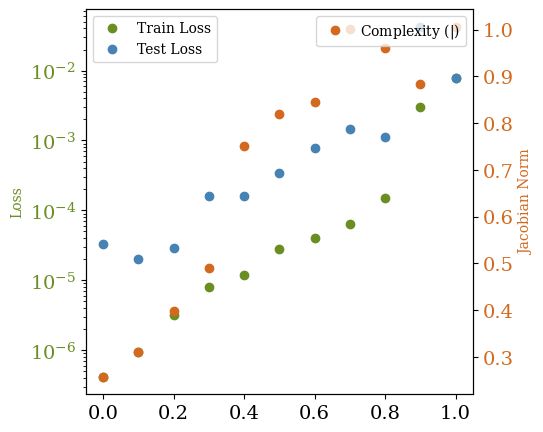

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(5, 5))

# Create a second y-axis for the Jacobian norm
ax2 = ax1.twinx()

# Define harmonious, colorblind-friendly colors
train_loss_color = '#6B8E23'  # Olive Green
test_loss_color = '#4682B4'   # Steel Blue
jacobian_norm_color = '#D2691E'  # Chocolate

# Plotting train_loss and test_loss on ax1
for i, row in df.iterrows():
    interpol_value = row['interpol_value']
    train_loss = row['train_loss']
    test_loss = row['test_loss']
    ax1.plot(interpol_value, train_loss, 'o', color=train_loss_color, label='Train Loss' if i == 0 else "")
    ax1.plot(interpol_value, test_loss, 'o', color=test_loss_color, label='Test Loss' if i == 0 else "")

# Plotting jacobian_norm on ax2
for i, row in df.iterrows():
    interpol_value = row['interpol_value']
    jacobian_norm = row['jacobian_norm']
    ax2.plot(interpol_value, jacobian_norm, 'o', color=jacobian_norm_color, label=r'Complexity ($\|\frac{\partial\Phi}{\partial x}-\mathbb{I}\|$)' if i == 0 else "")

# Set logarithmic scale for the loss axes
ax1.set_yscale('log')
ax1.set_ylabel('Loss', color=train_loss_color)
ax1.tick_params(axis='y', labelcolor=train_loss_color)

# Set linear scale for the Jacobian norm axis
ax2.set_ylabel('Jacobian Norm', color=jacobian_norm_color)
ax2.tick_params(axis='y', labelcolor=jacobian_norm_color)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


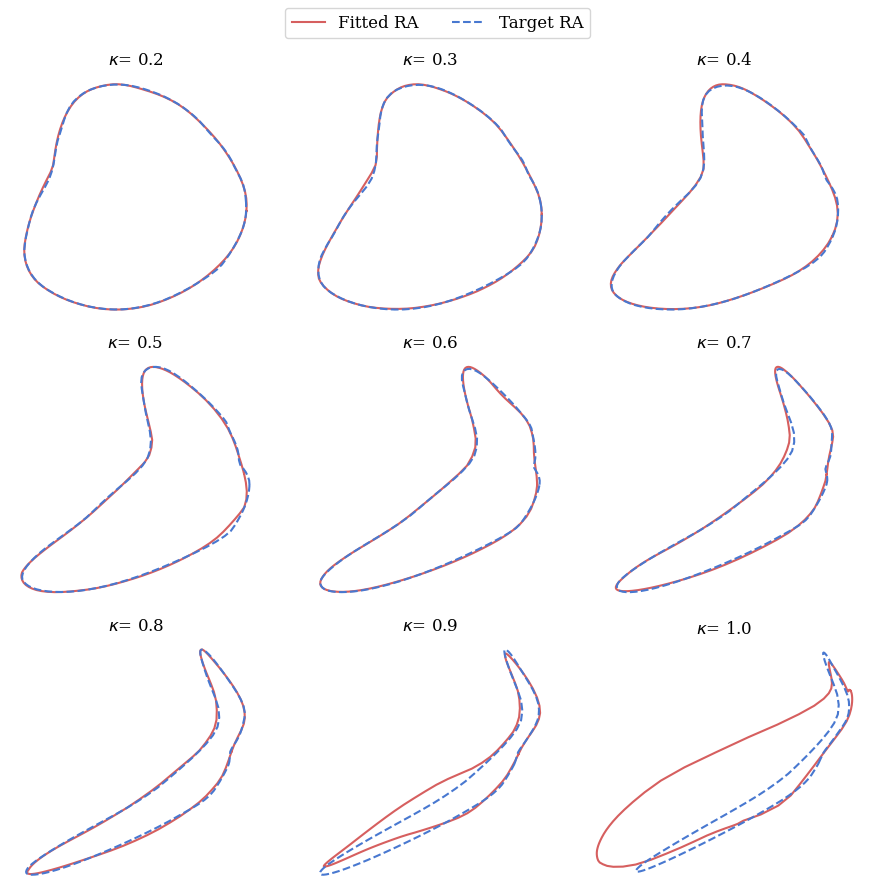

In [ ]:
# Select the last 9 entries
last_rows = df.tail(9).reset_index(drop=True)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for i, (ax, row) in enumerate(zip(axes, last_rows.iterrows())):
    row = row[1]  # iterrows() gives (index, row)

    fit_ra_points = row['fit_ra_points']
    target_ra_points = row['target_ra_points']
    
    ax.plot(fit_ra_points[:, 0], fit_ra_points[:, 1], 'r-', label='Fitted RA')
    ax.plot(target_ra_points[:, 0], target_ra_points[:, 1], 'b--', label='Target RA')
    ax.set_title(f"$\kappa$ = {row.interpol_value:.1f}")
    ax.set_aspect('equal')
    ax.axis('off')

# Add a single legend outside the subplots
fig.legend(['Fitted RA', 'Target RA'], loc='upper center', ncol=2, fontsize='large')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

Vector field perturbation experiment

In [ ]:
maxT = 20
tsteps = maxT*20
simulation_params = {"maxT": maxT, "tsteps": tsteps, "perturbation_norm": 0.01,
    "random_seed": 313, "min_val_sim": 3, "n_grid": 40,
    "add_limit_cycle": False,
    "num_points_invman": 200,
    "number_of_target_trajectories": 30, "initial_conditions_mode": "around_ring", "init_margin": 0.1}
X, Y, U_pert, V_pert, grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_man, trajectories_pertring = build_perturbed_ringattractor(**simulation_params)

trajectories_target = torch.tensor(trajectories_pertring, dtype=torch.float32)
initial_conditions_target = trajectories_target[:, 0, :]
trajectories_target.shape

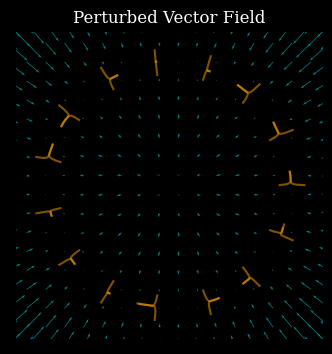

In [ ]:
# Plot the trajectories
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_aspect('equal')
ax.set_facecolor('black')
ax.set_title('Perturbed Vector Field', color='white')
ax.quiver(X, Y, U_pert, V_pert, color='teal', scale=15, label='Perturbed Vector Field')
for i in range(trajectories_pertring.shape[0]):
    ax.plot(trajectories_pertring[i, :, 0], trajectories_pertring[i, :, 1], color='orange', alpha=0.5)
#ax.plot(inv_man[:,0], inv_man[:,1], color='navy')
min_val_plot = 1.25
ax.set_xlim(-min_val_plot, min_val_plot), ax.set_xticks([])
ax.set_ylim(-min_val_plot, min_val_plot), ax.set_yticks([])
plt.show()

### Train homeomorphism and motif

In [ ]:
dim = 2
dt = simulation_params['maxT'] / simulation_params['tsteps']
time_span = torch.tensor([0.0, simulation_params['maxT']])
# assert int((time_span[1] - time_span[0])/dt) == int(tsteps), "time_span and dt for source do not match the simulation time of target"
# assert int(time_span[1] - time_span[0]) == int(maxT), "time_span and maxT for source do not match the simulation time of target"

homeo_type = 'iresnet'
layer_sizes = 5 * [32]
use_identity_init = True
homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'use_identity_init': use_identity_init}
homeo_lc = build_homeomorphism(homeo_params)

ds_motif = 'ring' #'lc', 'bla', 'stable', 'square',  
analytic = False
vf_on_ring_enabled = True #if analytic then not used
ds_params = {'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span, 'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled}
source_system_ra = build_ds_motif(**ds_params)
homeo_ds_net = Homeo_DS_Net(homeo_lc, source_system_ra)

lr = 0.00001
num_epochs = 20
annealing_params = {'dynamic': False, 'initial_std': .0, 'final_std': 0.}
training_params = {'lr': lr, 'num_epochs': num_epochs, 'annealing_params': annealing_params, 'early_stopping_patience': 1000, "batch_size": 2}
homeo_ds_net = train_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target, **training_params)
homeo_ds_net.training_params = training_params
homeo_ds_net.ds_params = ds_params
homeo_ds_net.homeo_params = homeo_params
homeo_ds_net.eval();
jac_norm = jacobian_norm_over_batch(homeo_lc, trajectories_target.reshape(-1,dim), norm_type='fro', normalize=True)
homeo_ds_net.jac_norm = jac_norm
#save_homeo_ds_net(homeo_ds_networks[0], f"model_pnorm{norm}_irn_.pth")

TypeError: train_homeo_ds_net() got an unexpected keyword argument 'batch_size'

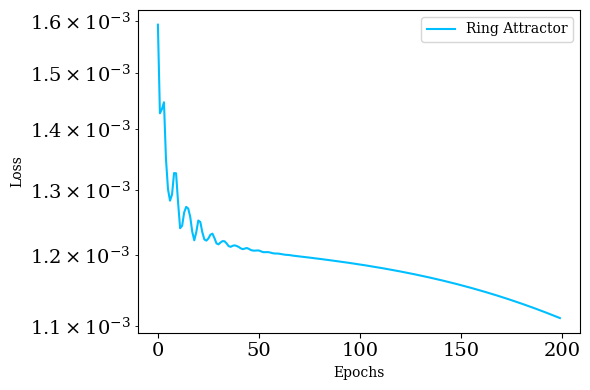

In [ ]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
motif_name = 'Ring Attractor'
motif_colors = ["#00BFFF", "#8B008B"]
ax.plot(homeo_ds_net.losses, label=motif_name, color=motif_colors[0])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

Losses: -2.9548876142571836


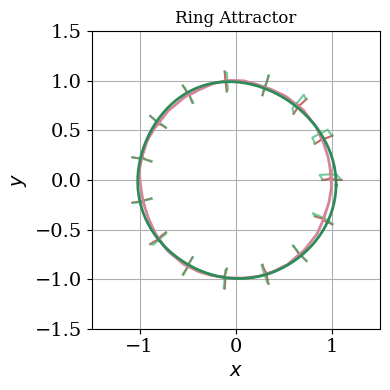

In [ ]:
plot_first_n = simulation_params['number_of_target_trajectories']
trajectories_source, transformed_trajectories, losses = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target)
fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network)
print(f"Losses: {np.log10(losses)}") 
plot_single_motif_trajectories(trajectories_source=trajectories_source, transformed_trajectories=transformed_trajectories, trajectories_target=trajectories_pertring, num_points=plot_first_n, bounds=(1.5, 1.5), which_axis='second', 
                            asymptotic_target=inv_man, asymptotic_source_transformed=fit_ra_points,
                            source_name='Ring Attractor', show_fig=True,save_name=f"figures/pertring_pnorm{simulation_params['perturbation_norm']}_irn_.pdf")

In [ ]:
#time length generalization
length_factor = 10
maxT_long = maxT/2*length_factor
tsteps_long = (tsteps-15)*length_factor
time_span_long = torch.tensor([0.0, time_span[1]*length_factor])
init_conds_trg = torch.tensor(inv_man, dtype=torch.float32)
trajectories_source_long, transformed_trajectories_long = generate_trajectories_from_initial_conditions(homeo_ds_net, init_conds_trg, time_span_long)

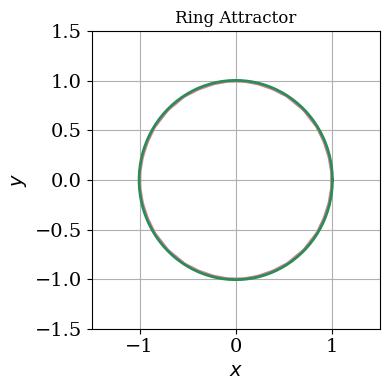

In [ ]:
plot_single_motif_trajectories(trajectories_source_long, transformed_trajectories_long, trajectories_pertring, source_name='Ring Attractor',
                            num_points=init_conds_trg.shape[0], bounds=(1.5, 1.5), which_axis='second', asymptotic_target=inv_man, asymptotic_source_transformed=fit_ra_points)

In [ ]:
#Remarks
# 1. y_0 is inferred well: inv_man == transformed_trajectories_list[0][:,0,:]

# 2. Asymptotic trajectories are not well inferred. nv_man != transformed_trajectories_list[0][:,-1,:]


#But if trained with on-manifold trajectories, then the invariant manifold is well inferred.

In [156]:
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

def radial_scale(r: np.ndarray, r_threshold: float = 1.1) -> np.ndarray:
    """Scale factor that increases up to r_threshold and flattens after."""
    scale = np.ones_like(r)
    mask = r <= r_threshold
    scale[mask] = r_threshold / (r[mask] + 1e-8)  # Avoid division by zero
    scale[~mask] = 1.0
    return scale

def plot_vector_field_fixedquivernorm_speedcontour(ax, X, Y, U, V, trajectories_pertring, title=None,
                                                   scale=1.0, color='teal', cmap='plasma', traj_color='k',
                                                   alpha=0.5, min_val_plot=1.25, vmin_log=-6, vmax_log=4,
                                                   smoothing_sigma=1.0, upsample_factor=8):
    """Plot a vector field with scaling and fixed log speed contour range."""
    speed = np.sqrt(U**2 + V**2)
    log_speed = np.log(speed + 1e-8)

    R = np.sqrt(X**2 + Y**2)
    scale_factor = radial_scale(R)
    U_scaled = U * scale_factor
    V_scaled = V * scale_factor

    # Normalize vectors for uniform arrow length
    U_unit = U / (speed + 1e-8)
    V_unit = V / (speed + 1e-8)

    # Interpolation to a finer grid
    x_fine = np.linspace(X.min(), X.max(), X.shape[1] * upsample_factor)
    y_fine = np.linspace(Y.min(), Y.max(), Y.shape[0] * upsample_factor)
    X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

    log_speed_fine = griddata(
        (X.flatten(), Y.flatten()),
        log_speed.flatten(),
        (X_fine, Y_fine),
        method='cubic',
        fill_value=np.nan
    )

    # Optional Gaussian smoothing
    log_speed_fine = gaussian_filter(log_speed_fine, sigma=smoothing_sigma)

    # Clip the log speed to a fixed range
    log_speed_fine = np.clip(log_speed_fine, vmin_log, vmax_log)

    # Plot setup
    plt.rcParams['axes.facecolor'] = 'black'
    plt.rcParams['figure.facecolor'] = 'black'
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_aspect('equal')
    ax.set_facecolor('black')
    ax.set_title(title, color='white')

    # Contour plot with fixed color limits
    contour = ax.contourf(X_fine, Y_fine, log_speed_fine, levels=100, cmap=cmap, alpha=0.8, vmin=vmin_log, vmax=vmax_log)

    # Colorbar
    cbar = plt.colorbar(contour, ax=ax, shrink=0.75)
    cbar.set_label('log speed', color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

    # Quiver
    ax.quiver(X, Y, U_unit, V_unit, color='white', scale=30)

    # Trajectories
    for i in range(trajectories_pertring.shape[0]):
        ax.plot(trajectories_pertring[i, :, 0], trajectories_pertring[i, :, 1], color=traj_color, alpha=0.5)

    ax.set_xlim(-min_val_plot, min_val_plot)
    ax.set_ylim(-min_val_plot, min_val_plot)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()


def plot_vector_field_coloredquivernorm(ax, X, Y, U, V, trajectories_pertring, title=None,
                                        cmap='plasma', traj_color='orange', alpha=0.5, save_name=None,
                                        min_val_plot=1.25, vmin_log=-6, vmax_log=4, background_color='white'):
    """Plot vector field with fixed-length quivers colored by log speed."""
    speed = np.sqrt(U**2 + V**2)
    log_speed = np.log(speed + 1e-8)
    log_speed = np.clip(log_speed, vmin_log, vmax_log)

    R = np.sqrt(X**2 + Y**2)
    scale_factor = radial_scale(R)
    U_scaled = U * scale_factor
    V_scaled = V * scale_factor

    # Normalize vectors for uniform arrow length
    U_unit = U / (speed + 1e-8)
    V_unit = V / (speed + 1e-8)

    if background_color == 'black':
        font_color = 'white'
    else:
        font_color = 'black'
    # Plot setup
    plt.rcParams['axes.facecolor'] = background_color
    plt.rcParams['figure.facecolor'] = background_color
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_aspect('equal')
    ax.set_facecolor(background_color)
    ax.set_title(title, color=font_color)

    # Quiver plot colored by log speed
    quiv = ax.quiver(X, Y, U_unit, V_unit, log_speed,
                     cmap=cmap, clim=(vmin_log, vmax_log), scale=30)

    # Colorbar for log speed
    cbar = plt.colorbar(quiv, ax=ax, shrink=0.75)
    cbar.set_label('log speed', color=font_color)
    cbar.ax.yaxis.set_tick_params(color=font_color)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=font_color)

    # Plot trajectories
    for i in range(trajectories_pertring.shape[0]):
        ax.plot(trajectories_pertring[i, :, 0], trajectories_pertring[i, :, 1],
                color=traj_color, alpha=alpha)

    ax.set_xlim(-min_val_plot, min_val_plot)
    ax.set_ylim(-min_val_plot, min_val_plot)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    if save_name:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)

    plt.show()

## Pertubation experiment

In [ ]:
def run_pert_ra_experiment(random_seed=313):
    save_dir = "experiments/vf_pert_ring/simple_ra"
    set_seed(random_seed)
    dim = 2
    maxT = 5
    tsteps = maxT*20
    max_perturbation_norm = .15
    pring_simulation_params = {"maxT": maxT, "tsteps": tsteps, "perturbation_norm": 0.01,
        "random_seed": 313, "min_val_sim": 3, "n_grid": 40,
        "add_limit_cycle": False,
        "num_points_invman": 200,
        "number_of_target_trajectories": 50, "initial_conditions_mode": "random", "init_margin": 0.25}
    
    ds_motif = 'ring' 
    dt = maxT / tsteps
    time_span = torch.tensor([0.0, maxT])
    analytic = True
    vf_on_ring_enabled = False #if analytic then not used
    training_pairs = False
    alpha_init = None
    if training_pairs:
        time_span = torch.tensor([0.0, dt])
    train_ratio = 0.8
    ds_params = {'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span, 'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled, 'alpha_init': alpha_init}
    simulation_params = {'initial_conditions_mode': 'random', 'number_of_target_trajectories': 50, 'time_span': time_span, 'dt': dt, 'noise_std': .0, 'max_perturbation_norm': max_perturbation_norm,
                        'training_pairs': training_pairs, 'margin': 0.5, 'seed': 42, 'train_ratio': train_ratio, 'ds_params': ds_params, 'pring_simulation_params': pring_simulation_params}
    
    homeo_type = 'node'
    layer_sizes = 1*[128]
    init_type = None
    homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': init_type}

    lr = 0.01
    num_epochs = 1000
    annealing_params = {'dynamic': False, 'initial_std': .0, 'final_std': 0.}
    training_params = {'lr': lr, 'num_epochs': num_epochs, 'annealing_params': annealing_params, 'early_stopping_patience': 1000, "batch_size": 32, 'use_inverse_formulation': True}
    
    all_parameters = { 'homeo_params': homeo_params, 'training_params': training_params, 'simulation_params': simulation_params}
    with open(f"{save_dir}/parameters.pkl", "wb") as f:
        pickle.dump(all_parameters, f)

    
    results = []
    for p_norm in np.arange(0.0, max_perturbation_norm + 0.001, 0.01):  # steps of 0.01
        p_norm = round(p_norm, 2)
        pring_simulation_params['perturbation_norm'] = p_norm
        print(f"Perturbation norm: {p_norm}")
        print("Creating perturbed ring attractor...")
        X, Y, U_pert, V_pert, grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_man, trajectories_pertring = build_perturbed_ringattractor(**pring_simulation_params) 
        trajectories_target = torch.tensor(trajectories_pertring, dtype=torch.float32)

        #init homeo_ds_net
        trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target, False)

        # Plot the trajectories
        # plot_vector_field_fixedquivernorm_speedcontour(ax, X, Y, U_pert, V_pert, trajectories_pertring, title=f"$\|{p_norm}\|$",
        #                                                scale=1.0, color='teal', alpha=0.5)
        # plot_vector_field_coloredquivernorm(ax, X, Y, U_pert, V_pert, trajectories_pertring, title=f"$\|{p_norm}\|$",
        #                                    traj_color='darkblue', cmap='inferno', save_name=f"{save_dir}/vf_{p_norm}.pdf")
        np.save(f"{save_dir}/trajectories_target_full_{p_norm}.npy", trajectories_target_full.detach().numpy())

        B = trajectories_target.shape[0]
        n_train = int(train_ratio * B)
        n_test = B - n_train
        train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
        trajectories_target_train = trajectories_target[train_set.indices]
        trajectories_target_test = trajectories_target[test_set.indices]

        #train homeo_ds_net
        homeo = build_homeomorphism(homeo_params)
        source_system_ra = build_ds_motif(**ds_params)
        homeo_ds_net = Homeo_DS_Net(homeo, source_system_ra)
        homeo_ds_net, losses, grad_norms = train_homeo_ds_net_batched(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train, **training_params)
        homeo_ds_net.eval()
        
        #test
        _, _, training_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train)
        _, _, test_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_test)
        fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network)
        jac_norm = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1,dim))

        results.append({
            "p_norm": p_norm,
            "train_loss": training_loss,
            "test_loss": test_loss,
            "jacobian_norm": jac_norm,
            "losses": losses,
            "grad_norms": grad_norms,
            "fit_ra_points": fit_ra_points,
            "target_ra_points": inv_man,
        })

        save_homeo_ds_net(homeo_ds_net, f"{save_dir}/homeo_{p_norm}.pth")
        np.save(f"{save_dir}/trajectories_target_{p_norm}.npy", trajectories_target.detach().numpy())

    df = pd.DataFrame(results)
    df.to_pickle(f"{save_dir}/summary_df.pkl")

Perturbation norm: 0.0
Creating perturbed ring attractor...


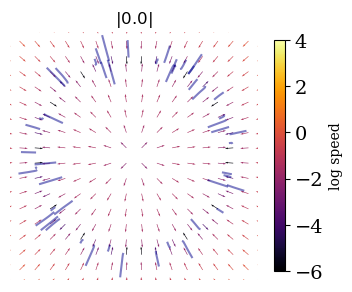

Perturbation norm: 0.01
Creating perturbed ring attractor...


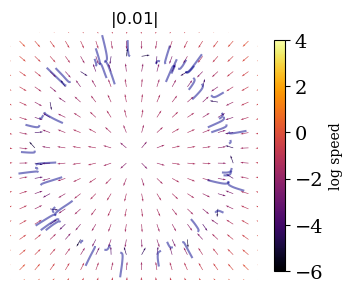

Perturbation norm: 0.02
Creating perturbed ring attractor...


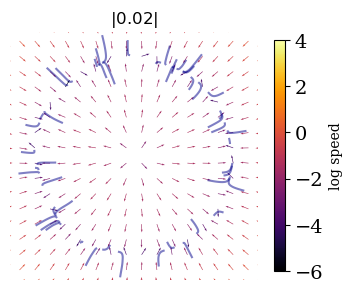

Perturbation norm: 0.03
Creating perturbed ring attractor...


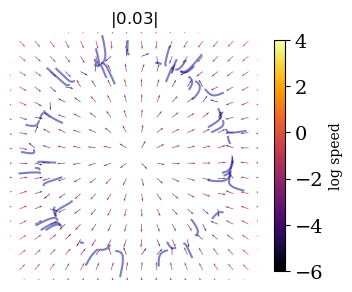

Perturbation norm: 0.04
Creating perturbed ring attractor...


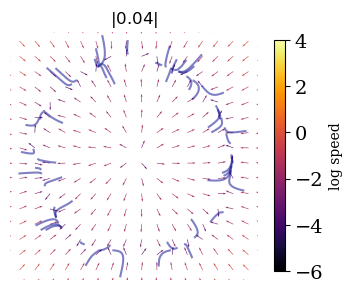

Perturbation norm: 0.05
Creating perturbed ring attractor...


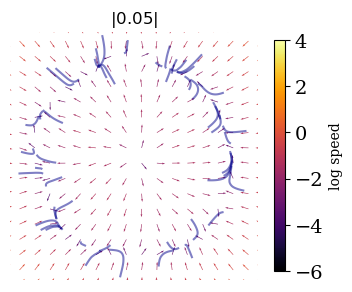

Perturbation norm: 0.06
Creating perturbed ring attractor...


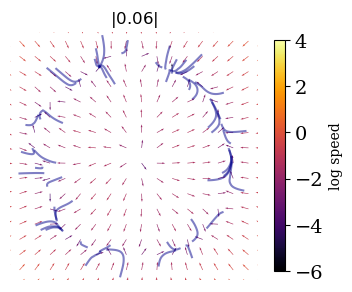

Perturbation norm: 0.07
Creating perturbed ring attractor...


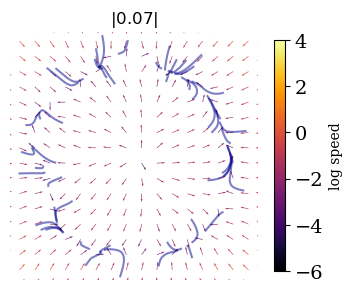

Perturbation norm: 0.08
Creating perturbed ring attractor...


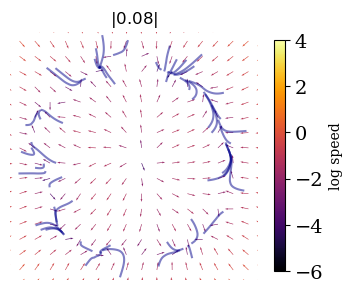

Perturbation norm: 0.09
Creating perturbed ring attractor...


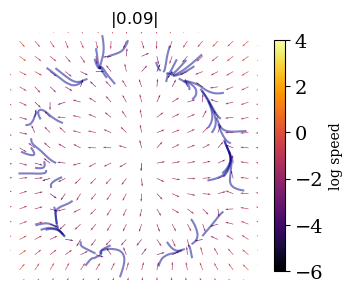

Perturbation norm: 0.1
Creating perturbed ring attractor...


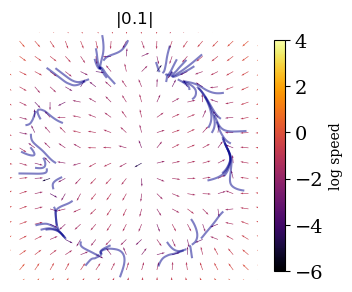

Perturbation norm: 0.11
Creating perturbed ring attractor...


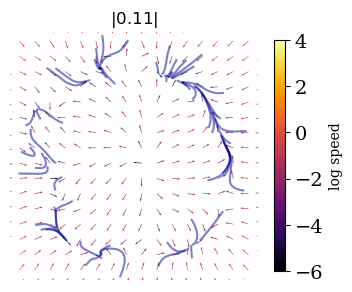

Perturbation norm: 0.12
Creating perturbed ring attractor...


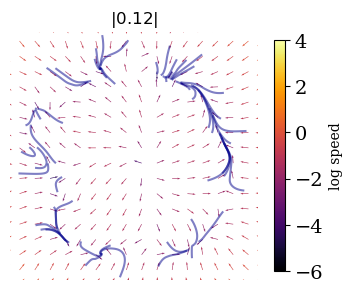

Perturbation norm: 0.13
Creating perturbed ring attractor...


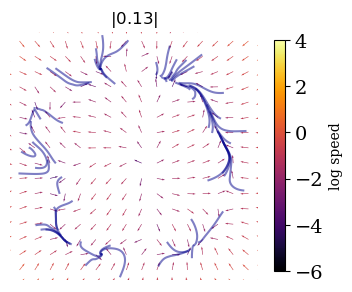

Perturbation norm: 0.14
Creating perturbed ring attractor...


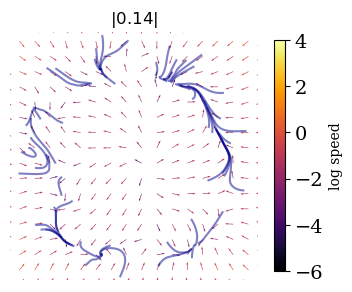

Perturbation norm: 0.15
Creating perturbed ring attractor...


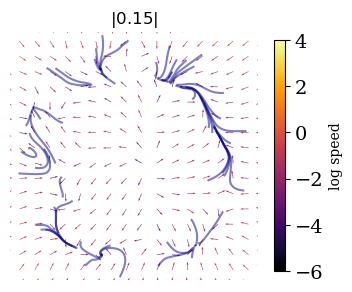

In [158]:
run_pert_ra_experiment()

In [87]:
df = pd.read_pickle("experiments/vf_pert_ring/simple_ra/summary_df.pkl")
df

,p_norm,train_loss,test_loss,jacobian_norm,losses,grad_norms,fit_ra_points,target_ra_points
0,0.00,0.000005,0.000016,tensor(0.2731),"[0.060234380420297384, 0.02491100924089551, 0....","[0.9227514266967773, 0.3237047493457794, 0.370...","[[1.3700534, 0.0064405953], [1.3545249, 0.0973...","[[0.996498421377358, 2.2248785406467515e-20], ..."
1,0.01,0.000008,0.000031,tensor(0.2387),"[0.029802618781104684, 0.02732300478965044, 0....","[0.7540488839149475, 0.2281893491744995, 0.739...","[[1.3729937, -0.13525692], [1.3683887, -0.0447...","[[0.996498421377358, 2.2248785406467515e-20], ..."
2,0.02,0.000004,0.000039,tensor(0.2543),"[0.07549101300537586, 0.019553394056856632, 0....","[0.9405446648597717, 0.5221431851387024, 0.476...","[[1.3771726, -0.2753552], [1.3814723, -0.17769...","[[0.996498421377358, 2.2248785406467515e-20], ..."
3,0.03,0.000008,0.000059,tensor(0.2513),"[0.02628956502303481, 0.021584169007837772, 0....","[0.5053292512893677, 0.25889647006988525, 0.50...","[[1.3669598, -0.34837484], [1.3761562, -0.2623...","[[0.996498421377358, 2.2248785406467515e-20], ..."
4,0.04,0.000005,0.000039,tensor(0.2674),"[0.08767790719866753, 0.01619658200070262, 0.0...","[0.855789065361023, 0.9227392673492432, 0.2103...","[[1.3705962, -0.3338382], [1.3787267, -0.24215...","[[0.996498421377358, 2.2248785406467515e-20], ..."
5,0.05,0.000006,0.000026,tensor(0.2512),"[0.06481701601296663, 0.015989144798368216, 0....","[0.8631800413131714, 0.5546931624412537, 0.270...","[[1.3812008, -0.16874872], [1.3778943, -0.0703...","[[0.996498421377358, 2.2248785406467515e-20], ..."
6,0.06,0.000003,0.000370,tensor(0.2523),"[0.05489150620996952, 0.02943513449281454, 0.0...","[0.8167324066162109, 0.5072470903396606, 0.357...","[[1.3783333, -0.24147645], [1.3798811, -0.1494...","[[0.996498421377358, 2.2248785406467515e-20], ..."
7,0.07,0.000005,0.000023,tensor(0.2623),"[0.0525368582457304, 0.013940030243247747, 0.0...","[0.7429983019828796, 0.4007206857204437, 0.405...","[[1.3690907, -0.34182516], [1.3770862, -0.2500...","[[0.996498421377358, 2.2248785406467515e-20], ..."
8,0.08,0.000003,0.000035,tensor(0.2860),"[0.04422400472685695, 0.01883891923353076, 0.0...","[0.8677796125411987, 0.3280033469200134, 0.271...","[[1.3781638, -0.10414748], [1.3702397, -0.0110...","[[0.996498421377358, 2.2248785406467515e-20], ..."
9,0.09,0.000004,0.000028,tensor(0.3037),"[0.08270993083715439, 0.0073540485464036465, 0...","[0.8088546395301819, 0.5600593090057373, 0.155...","[[1.3577598, -0.43156436], [1.3716305, -0.3382...","[[0.996498421377358, 2.2248785406467515e-20], ..."


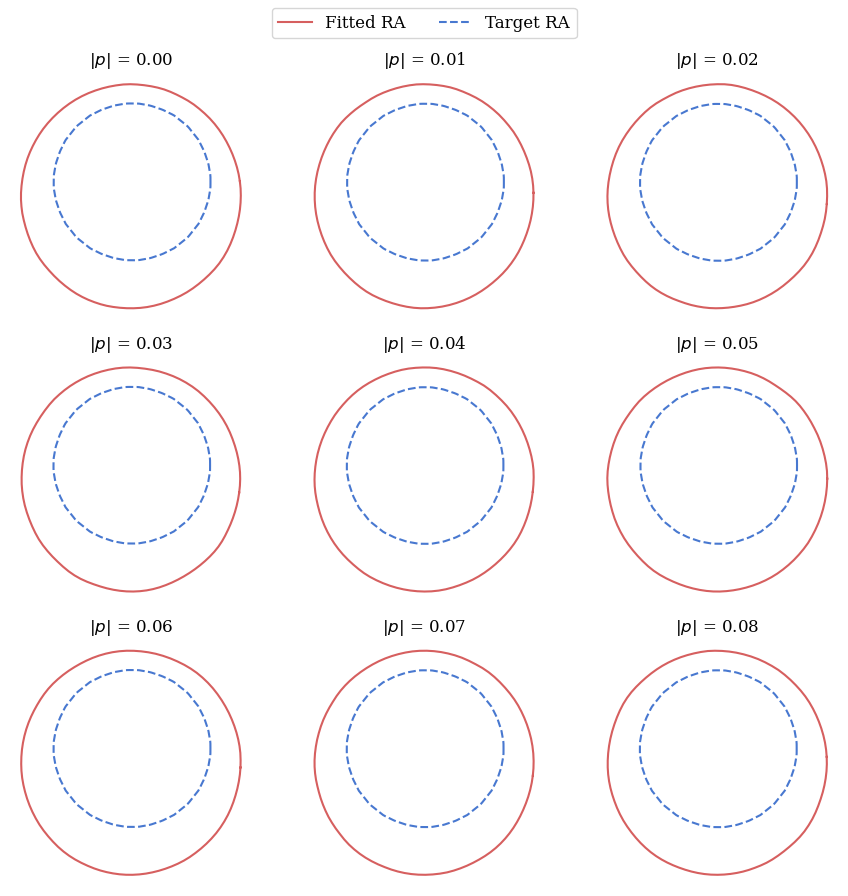

In [91]:
# Select the last 9 entries
last_rows = df.head(9).reset_index(drop=True)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for i, (ax, row) in enumerate(zip(axes, last_rows.iterrows())):
    row = row[1]  # iterrows() gives (index, row)

    fit_ra_points = row['fit_ra_points']
    target_ra_points = row['target_ra_points']
    
    ax.plot(fit_ra_points[:, 0], fit_ra_points[:, 1], 'r-', label='Fitted RA')
    ax.plot(target_ra_points[:, 0], target_ra_points[:, 1], 'b--', label='Target RA')
    ax.set_title(f"$\|p\|$ = {row.p_norm:.2f}")
    ax.set_aspect('equal')
    ax.axis('off')

# Add a single legend outside the subplots
fig.legend(['Fitted RA', 'Target RA'], loc='upper center', ncol=2, fontsize='large')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()